# _Drosophila melanogaster_ male courtship song

Requires _DAS_ to be installed. See [documentation](https://janclemenslab.org/das/installation.html) for instructions.

Sample data from:   
Clemens J, Coen P, Roemschied FA, Pereira TD, Mazumder D, Aldarondo DE, Pacheco DA, Murthy M. 2018.   
Discovery of a New Song Mode in Drosophila Reveals Hidden Structure in the Sensory and Neural Drivers of Behavior.   
Current biology 28:2400–2412.e6.   
Original data deposited at [https://doi.org/10.25625/8KAKHJ().

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.feature, librosa.display
import das.utils_plot, das.predict, das.train, das.utils_plot, das.menagerie
from pprint import pprint

plt.style.use('../ncb.mplstyle')

## Download data from the repository
Release: [https://github.com/janclemenslab/das-menagerie/releases/Dmel_multi_v1.0/]()

`data.npz` contains the following variables
- `x`: the audio data `[nb_samples, nb_channels]
- `samplerate_Hz`: audio sample rate in Hz
- `y_true_sine`, `y_true_pulse`: groundtruth annotations `[nb_samples, nb_classes]`
- `class_names_sine`, `class_names_pulse`: class names `[nb_classes,]`

dict_keys(['x', 'y_true_pulse', 'y_true_sine', 'class_names_pulse', 'class_names_sine', 'samplerate_Hz'])


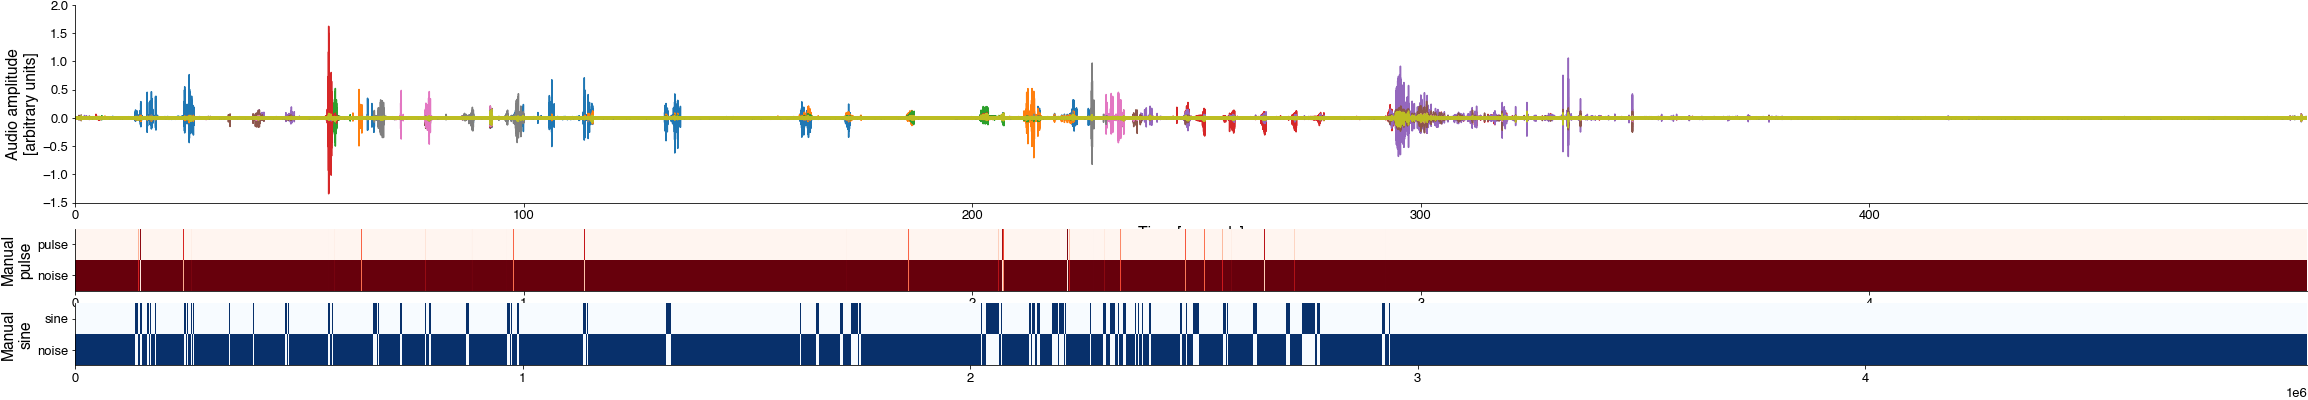

In [2]:
url = "https://github.com/janclemenslab/das-menagerie/releases/download/Dmel_multi_v1.0/data.npz"
data = das.menagerie.load_data(url)
print(data.keys())

samplerate_Hz = data['samplerate_Hz']
T = np.arange(len(data['x'])) / samplerate_Hz

plt.figure(figsize=(40, 8))
plt.subplot(211)
plt.plot(T, data['x'])
plt.xlim(T[0], T[-1])
plt.xlabel('Time [seconds]')
plt.ylabel('Audio amplitude\n[arbitrary units]')

plt.subplot(614)
plt.imshow(data['y_true_pulse'].T, cmap='Reds')
plt.yticks(np.arange(len(data['class_names_pulse'])), labels=data['class_names_pulse'])
plt.ylabel('Manual\npulse')

plt.subplot(615)
plt.imshow(data['y_true_sine'].T, cmap='Blues')
plt.yticks(np.arange(len(data['class_names_sine'])), labels=data['class_names_sine'])
plt.ylabel('Manual\nsine')

plt.show()

## Generate annotations using _DAS_
Using `das.predict`

Returns:
- `events`: Blah. Important keys: 
- `segments`: Blah. Important keys: 
- `class_probabilities`: 
- `class_names`:

In [3]:
model_path_pulse = 'https://github.com/janclemenslab/das-menagerie/releases/download/Dmel_multi_v1.0/pulse'
events, _, pulse_probabilities, pulse_class_names = das.predict.predict(data['x'], model_path_pulse, event_thres=0.5, event_dist=0.01)

/Users/clemens10/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1061: UserWarning: dss.tcn.tcn is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/Users/clemens10/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [4]:
model_path_sine = 'https://github.com/janclemenslab/das-menagerie/releases/download/Dmel_multi_v1.0/sine'
_, segments, sine_probabilities, sine_class_names = das.predict.predict(data['x'], model_path_sine, segment_minlen=0.02, segment_fillgap=0.02)

## Plot _DAS_ and manual annotations

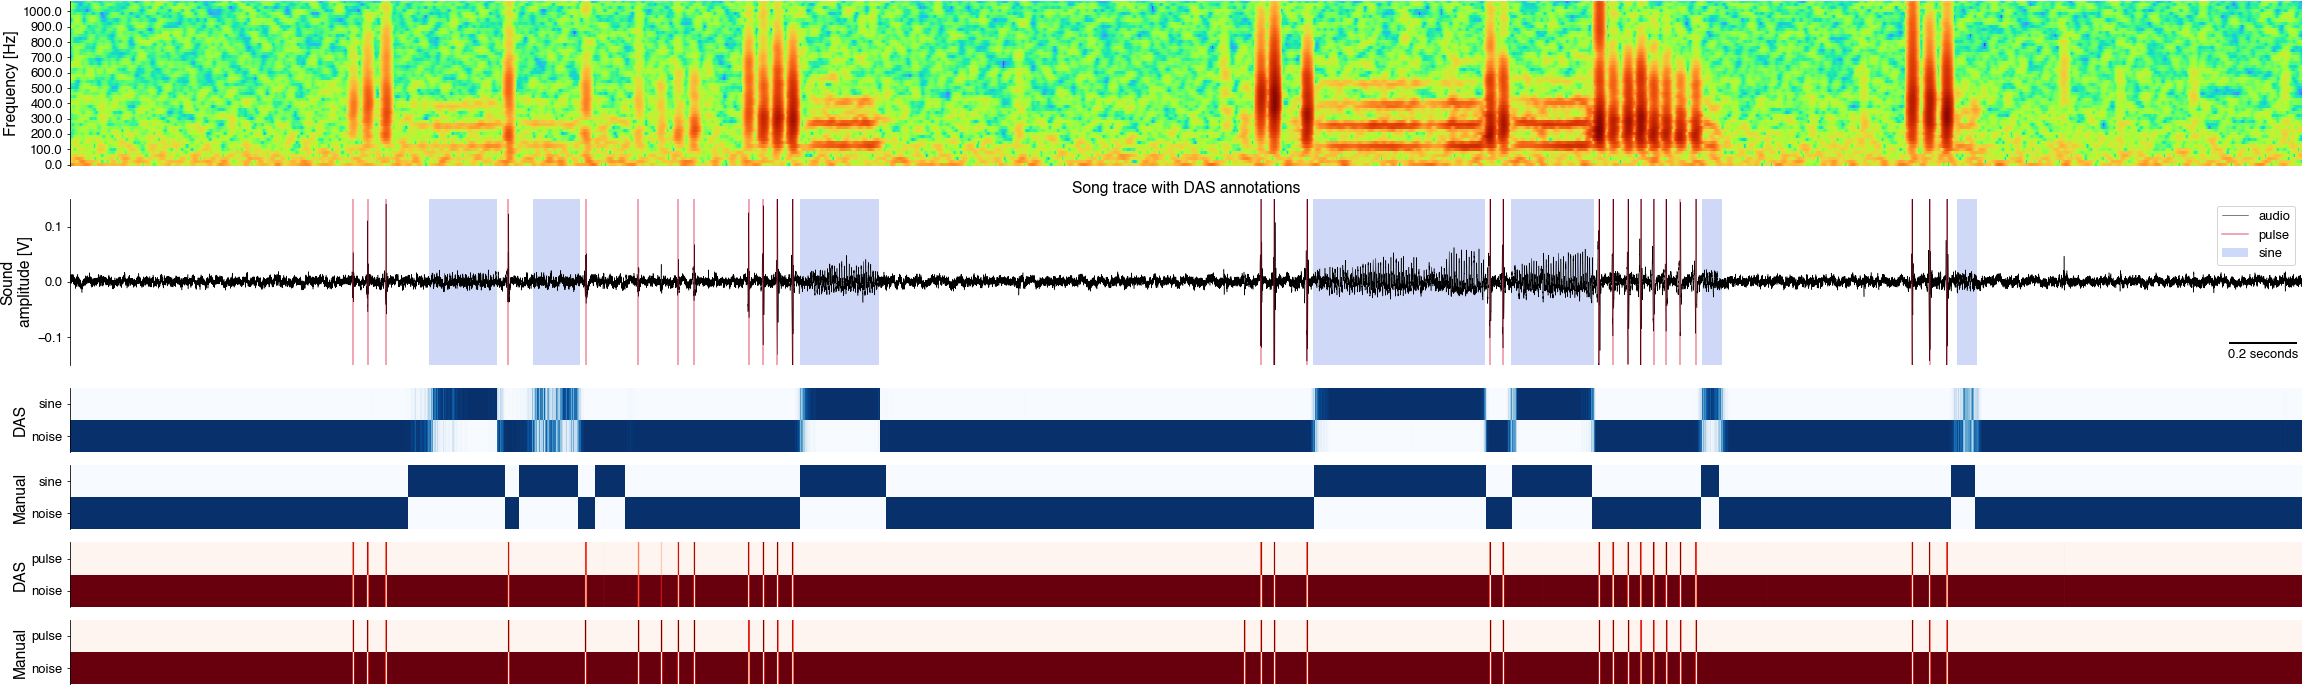

In [8]:
i0, i1 = int(1.25e5), int(1.9e5)
T = np.arange(i0, i1) / samplerate_Hz

specgram = librosa.feature.melspectrogram(data['x'][i0:i1, 0], sr=samplerate_Hz, n_fft=512, hop_length=16, power=1)
specgram = librosa.amplitude_to_db(specgram, ref=np.max(specgram))
freqs = np.round(librosa.mel_frequencies(n_mels=128, fmin=0.0, fmax=samplerate_Hz/2, htk=False)/10) * 10

freqs = freqs[freqs<1_100]
freq_ticks = np.where(np.mod(freqs, 100)<=10)[0]
freq_labels, idx = np.unique(np.round(freqs[freq_ticks]/100)*100, return_index=True)
freq_ticks = freq_ticks[idx]


plt.figure(figsize=(40, 14))
plt.subplot(4, 1, 1)
plt.imshow(specgram[:len(freqs), :], cmap='turbo')
plt.yticks(freq_ticks, labels=freq_labels)
plt.ylabel('Frequency [Hz]')
das.utils_plot.despine(which='tbr')

plt.subplot(4, 1, 2)
plt.plot(T, data['x'][i0:i1, 0], c='k', linewidth=0.5, label='audio')
das.utils_plot.annotate_events(event_seconds=events['seconds'], event_names=events['sequence'], tmin=T[0], tmax=T[-1], color='crimson')
das.utils_plot.annotate_segments(onset_seconds=segments['onsets_seconds'], offset_seconds=segments['offsets_seconds'], segment_names=segments['sequence'], tmin=T[0], tmax=T[-1], color='royalblue')
plt.xlim(T[0], T[-1])
plt.ylim(-0.15, 0.15)
plt.yticks(np.arange(-0.1, 0.15, 0.1))
plt.legend(loc='upper right', frameon=True, facecolor='w')
plt.ylabel('Sound\namplitude [V]')
plt.title('Song trace with DAS annotations')
das.utils_plot.despine(which='tbr')
das.utils_plot.scalebar(length=0.2, units='seconds')

plt.subplot(10, 1, 6)
plt.imshow(sine_probabilities[i0:i1, :].T, cmap='Blues')
plt.yticks(np.arange(len(sine_class_names)), labels=sine_class_names)
plt.ylabel('DAS')
das.utils_plot.despine(which='tbr')

plt.subplot(10, 1, 7)
plt.imshow(data['y_true_sine'][i0:i1].T, cmap='Blues')
plt.yticks(np.arange(len(sine_class_names)), labels=sine_class_names)
plt.ylabel('Manual')
das.utils_plot.despine(which='tbr')

plt.subplot(10, 1, 8)
plt.imshow(pulse_probabilities[i0:i1, :].T, cmap='Reds')
plt.yticks(np.arange(len(pulse_class_names)), labels=pulse_class_names)
plt.ylabel('DAS')
das.utils_plot.despine(which='tbr')

plt.subplot(10, 1, 9)
plt.imshow(data['y_true_pulse'][i0:i1].T, cmap='Reds')
plt.yticks(np.arange(len(pulse_class_names)), labels=pulse_class_names)
plt.ylabel('Manual')
das.utils_plot.despine(which='tbr')

plt.show()

## Evaluate performance for sine

In [6]:
# TODO

## Evaluate performance for pulse

In [7]:
# TODO